In [ ]:
import pandas as pd 
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# scrape data on our own w/ read_html
# will return a bunch of different dfs in a list
# for now (since we're in november), we only want 0 and 1
# however, in subsequent months, we will want every month
# we'll get each dataframe in a loop and stop once it starts giving us season averages (at bottom of webpage)

# full dataframe for our amalgamated data from webpage
data = pd.DataFrame()

# df of all tables on webpage
df = pd.read_html("https://www.espn.co.uk/nba/player/gamelog/_/id/4065648/jayson-tatum")


for record in range(len(df)): # each table pulled from website

    # check if we see 'Regular Season Stats' as first col - indicates that we've reached the tables we don't want
    if df[record].columns[0] == 'Regular Season Stats':
        print(f"{record} tables found.")
        break

    # if conditional isn't hit, clean df and append to data
    df[record].drop(df[record].tail(1).index, inplace=True) # drop last row - totals for the month
    data = data.append(df)
    

2 tables found.


/tmp/ipykernel_32111/1147837088.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(df)


In [ ]:
#data.to_csv("tatum.csv")

In [ ]:
data = pd.read_csv("tatum.csv")

In [ ]:
data.drop(columns={"Unnamed: 0"}, inplace=True)
data.dropna(subset={"Date"}, inplace=True)
data = data[data["Date"] != "october"]
data = data[data["Date"] != "NBA Canada Series"]
data.drop(columns=["STRK", "GB", "PCT", "W", "L", "Team", "Regular Season Stats"], inplace=True)


In [ ]:
# set max columns

pd.set_option('display.max_columns', 500)


In [ ]:
# create some features for the model

# find average PTS for the last 10 games using .shift
#data["PTS_10"] = data["PTS"].shift(1).rolling(10).mean()

In [ ]:
# create various variables for stats from previous games
data["PTS_last_game"] = data["PTS"].shift(-1)
data["min_last_game"] = data["MIN"].shift(-1)
data["fg_pct_last_game"] = data["FG%"].shift(-1)
data["fg3_pct_last_game"] = data["3P%"].shift(-1)
data["ft_pct_last_game"] = data["FT%"].shift(-1)
data["reb_last_game"] = data["REB"].shift(-1)
data["ast_last_game"] = data["AST"].shift(-1)
data["stl_last_game"] = data["STL"].shift(-1)
data["blk_last_game"] = data["BLK"].shift(-1)
#data["tov_last_game"] = data["TOV"].shift(-1)
data["pf_last_game"] = data["PF"].shift(-1)


In [ ]:
data_rev = data.copy()

# reverse sort dataset to ensure rolling mean calculated correctly
data_rev = data_rev.iloc[::-1]

# calculate 10 day rolling average for points
data_rev["PTS_10"] = data_rev["PTS_last_game"].rolling(10).mean()

# calculate 5 day rolling average for points
data_rev["PTS_5"] = data_rev["PTS_last_game"].rolling(5).mean()


# calculate average minutes over last 5 games
data_rev["min_5"] = data_rev["min_last_game"].rolling(5).mean()

# calculate average fg_pct over last 5 games
data_rev["fg_pct_5"] = data_rev["fg_pct_last_game"].rolling(5).mean()

# calculate average fg3_pct over last 5 games
data_rev["fg3_pct_5"] = data_rev["fg3_pct_last_game"].rolling(5).mean()

# calculate average ft_pct over last 5 games
data_rev["ft_pct_5"] = data_rev["ft_pct_last_game"].rolling(5).mean()

# calculate average reb over last 5 games
data_rev["reb_5"] = data_rev["reb_last_game"].rolling(5).mean()

# calculate average ast over last 5 games
data_rev["ast_5"] = data_rev["ast_last_game"].rolling(5).mean()

# calculate average stl over last 5 games
data_rev["stl_5"] = data_rev["stl_last_game"].rolling(5).mean()

# calculate average blk over last 5 games
data_rev["blk_5"] = data_rev["blk_last_game"].rolling(5).mean()

# calculate average tov over last 5 games
#data_rev["tov_5"] = data_rev["tov_last_game"].rolling(5).mean()

# calculate average pf over last 5 games
data_rev["pf_5"] = data_rev["pf_last_game"].rolling(5).mean()



In [ ]:
# change some data types to speed up code later + enable pairplots and correlation heatmap

#data_rev["MIN"] = data_rev["MIN"].astype("float")
data_rev["PTS"] = data_rev["PTS"].astype("float")
#data_rev["PTS_last_game"] = data_rev["PTS_last_game"].astype("float")
#data_rev["min_last_game"] = data_rev["min_last_game"].astype("float")
#data_rev["PTS_10"] = data_rev["PTS_10"].astype("float")


In [ ]:
# function to take weekday out of date column in data_rev
def get_weekday(date):
    return date.split(" ")[1]

# apply function to data_rev
data_rev["gameday"] = data_rev["Date"].apply(lambda x: get_weekday(x))

# function to add year to gameday column
def add_year(gameday):
    if int(gameday.split("/")).isin([10, 11, 12]):
        return f"{gameday}/2022"
    else:
        return f"{gameday}/2021"

# add year to gameday col
data_rev["gameday"] = data_rev["gameday"].apply(lambda x: add_year(x))

# convert date to datetime object
data_rev["gameday"] = data_rev["gameday"].apply(lambda x: pd.to_datetime(x, format='%m/%d'))
#df['Date'].dt.strftime('%b %d/%y')

# function that takes date and determines whether it's a back-to-back
#def back_to_back(date):


In [ ]:
data_rev.head()

,Date,OPP,Result,MIN,FG,FG%,3PT,3P%,FT,FT%,REB,AST,BLK,STL,PF,TO,PTS,PTS_last_game,min_last_game,fg_pct_last_game,fg3_pct_last_game,ft_pct_last_game,reb_last_game,ast_last_game,stl_last_game,blk_last_game,pf_last_game,PTS_10,PTS_5,min_5,fg_pct_5,fg3_pct_5,ft_pct_5,reb_5,ast_5,stl_5,blk_5,pf_5,gameday
49,Sun 10/2,vsCHA,W134-93,22,4-11,36.4,2-8,25.0,6-6,100.0,6,3,0,2,1,5,16.0,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1900-10-02
48,Thu 10/6,vsTOR,L125-119 OT,29,6-16,37.5,0-7,0.0,6-7,85.7,10,4,0,0,1,1,18.0,16,22,36.4,25.0,100.0,6,3,2,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1900-10-06
46,Sat 10/15,vsTOR,L137-134 OT,29,6-15,40.0,3-10,30.0,6-6,100.0,9,6,0,0,4,3,21.0,18,29,37.5,0.0,85.7,10,4,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1900-10-15
43,Wed 10/19,vsPHI,W126-117,39.0,13-20,65.0,2-7,28.6,7-9,77.8,12.0,4.0,1.0,1.0,1.0,3.0,35.0,21,29,40.0,30.0,100.0,9,6,0,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1900-10-19
42,Sat 10/22,@MIA,W111-104,37.0,10-22,45.5,2-7,28.6,7-7,100.0,5.0,4.0,2.0,1.0,1.0,2.0,29.0,35.0,39.0,65.0,28.6,77.8,12.0,4.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1900-10-22


## Choosing some Features

### Pairplot - look for relationships

In [ ]:
sns.pairplot(data_rev)

### Correlation Heatmap

/tmp/ipykernel_22596/405069642.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data_rev.corr(), annot=True, cmap="coolwarm")


<AxesSubplot: >

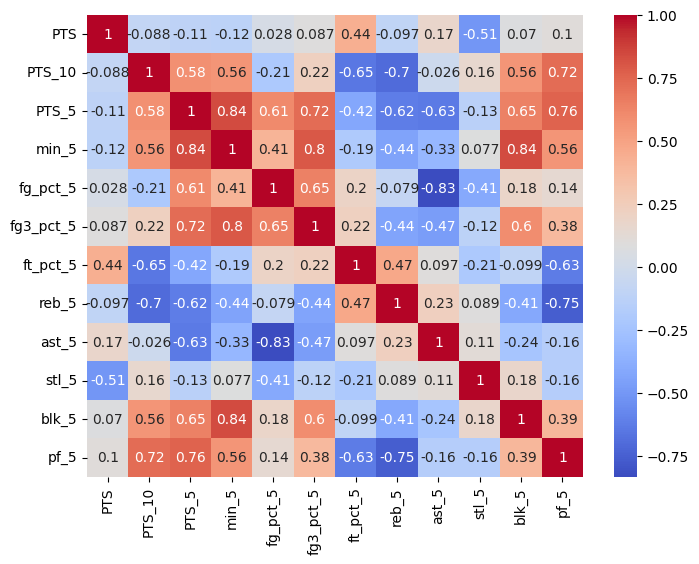

In [ ]:
plt.figure(figsize=(8,6))

sns.heatmap(data_rev.corr(), annot=True, cmap="coolwarm")